## Advisory 
### If you have not yet begun the project 
Please do not use this workspace.  Use the AWS resources provided and the instructions from the [cloud computing lesson](https://classroom.udacity.com/nanodegrees/nd101/parts/b9c4c3c3-b524-427b-8832-9d0748f14a2e/modules/de12f7bf-d980-4998-ab91-0e411184c878/lessons/29df00d8-01c2-4995-92fa-a4afd020be90/concepts/80d2ed46-1bba-413e-891e-610259017251).
### If you have started on this workspace
Please consider downloading your Jupyter notebook and then following the instructions above on using AWS instead.  You can upload your current work to AWS through your GitHub account.  


As a reminder, the project can be found on the [deep learning GitHub page](https://github.com/udacity/deep-learning/tree/master/face_generation).
These warnings are given because the project frequently generates more data than the workspace can handle, causing loading problems and lost work.  Please use [the forums](https://discussions.udacity.com/c/nd101-part-5-GANs/nd101-generate-faces) if you have any questions on the project or its setup.


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

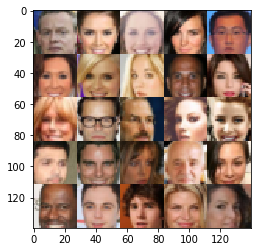

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels])
    
    z_input = tf.placeholder(dtype=tf.float32, shape=[None, z_dim])
    
    learning_rate = tf.placeholder(dtype=tf.float32, shape=[])

    return inputs, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):

        # conv -> batch_norm -> leakyReLU
        
        # first layer won't have activation fn
        
        # find shape of image
        # can be greyscale or color
        input_channel_dim = images.get_shape()[-1]
        

        # either [28,28,1] or [28,28,3] coming in
        x1 = tf.layers.conv2d(inputs=images,
                              filters=32,
                              kernel_size=[5,5],
                              strides=[2,2],
                              padding='same')
        x1 = tf.layers.batch_normalization(inputs=x1, training=True)
        x1 = tf.maximum(x1 * alpha, x1)
        # now it's [14,14,32]
        
        
        x2 = tf.layers.conv2d(inputs=x1,
                              filters=64,
                              kernel_size=[5,5],
                              strides=[2,2],
                              padding='same')
        x2 = tf.layers.batch_normalization(inputs=x2, training=True)
        x2 = tf.maximum(x2 * alpha, x2)
        # now it's [7,7,64]
        
        
        x3 = tf.layers.conv2d(inputs=x2,
                              filters=128,
                              kernel_size=[5,5],
                              strides=[2,2],
                              padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=True)
        x3 = tf.maximum(x3 * alpha, x3)
        # now it's [4,4,128]
        
        flatten = tf.reshape(x3, [-1,4*4*128])
                
        logits = tf.contrib.layers.fully_connected(inputs=flatten,
                                                   num_outputs=1,
                                                   activation_fn=None,
                                                   weights_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.02))
        
        out = tf.sigmoid(logits)

    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # TODO: Implement Function

        # deconv -> batch_norm -> leakyReLU

        # z vector coming in
        x1 = tf.contrib.layers.fully_connected(inputs=z,
                                               num_outputs=4*4*512,
                                               activation_fn=None,
                                               weights_initializer=tf.truncated_normal_initializer(mean=0.0,stddev=0.02))

        x1 = tf.reshape(x1, [-1,4,4,512])
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        # now shape [4,4,512]

        x2 = tf.layers.conv2d_transpose(inputs=x1,
                                        filters=256,
                                        kernel_size=[4,4],
                                        strides=[1,1],
                                        padding='valid')
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_train)
        x2 = tf.maximum(x2 * alpha, x2)
        # [7,7,256]


        x3 = tf.layers.conv2d_transpose(inputs=x2,
                                        filters=128,
                                        kernel_size=[5,5],
                                        strides=[2,2],
                                        padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3,training=is_train)
        x3 = tf.maximum(x3 * alpha, x3)
        # now [14,14,128]


        x4 = tf.layers.conv2d_transpose(inputs=x3,
                                        filters=out_channel_dim,
                                        kernel_size=[5,5],
                                        strides=[2,2],
                                        padding='same')
        # [28,28,out_channel_dim]

        logits = x4

        out = tf.tanh(logits)

        # last layer doesn't need activation function
        # shape should end with [28,28,1] or [28,28,3]

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    input_fake = generator(input_z,out_channel_dim)
    
    d_real_logits,d_real_out = discriminator(input_real)
    d_fake_logits,d_fake_out = discriminator(input_fake,reuse=True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=d_real_logits,labels=tf.ones_like(d_real_out)))
    
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=d_fake_logits,labels=tf.zeros_like(d_fake_out)))
    # d_loss = sum of loss with real and fake images
    d_loss = d_loss_real + d_loss_fake
    
    # g_loss
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_fake_logits,labels=tf.ones_like(d_fake_out)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # get trainable variables
    d_vars = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
    g_vars = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
    
    # use the variables for the optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(loss=d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(loss=g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, l_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #reset the graph
    
    channel_dim = 1 if data_image_mode=='L' else 3
    
    # build input tensors placeholders
    inputs, z_input, _ = model_inputs(image_width=data_shape[1],
                                                  image_height=data_shape[1],
                                                  image_channels=channel_dim,
                                                  z_dim=z_dim)
        
    # build the loss tensors
    d_loss, g_loss = model_loss(inputs,z_input,channel_dim)
    
    # build the optimizers
    d_train_opt, g_train_opt = model_opt(d_loss,g_loss,l_rate,beta1)
    
    # checkpoint saver
    saver = tf.train.Saver()
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                # sample random noise z for generator
                batch_z = np.random.uniform(-1.0,1.0,size=(batch_size,z_dim))
                
                # run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs:batch_images, z_input:batch_z})
                _ = sess.run(g_train_opt, feed_dict={z_input:batch_z, inputs:batch_images})
                
                # print info every 10 steps
                if steps%10==0:
                    # At the end of each epoch, get the losses and print them out
                    d_train_loss = d_loss.eval({z_input: batch_z, inputs: batch_images})
                    g_train_loss = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                    
                # show generator output every 100 steps
                if steps%100==0:
                    show_generator_output(sess, n_images=25, input_z=z_input, out_channel_dim=channel_dim, image_mode=data_image_mode)

        saver.save(sess,'./checkpoints/generator.ckpt')
    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
!pip install matplotlib==2.2.2

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.5409
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.5858
Epoch 1/2... Discriminator Loss: 0.3653... Generator Loss: 1.7005
Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 1.2495
Epoch 1/2... Discriminator Loss: 0.6821... Generator Loss: 1.1535
Epoch 1/2... Discriminator Loss: 0.5014... Generator Loss: 1.4690
Epoch 1/2... Discriminator Loss: 0.6477... Generator Loss: 1.0292
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 2.0286
Epoch 1/2... Discriminator Loss: 0.6156... Generator Loss: 1.3088
Epoch 1/2... Discriminator Loss: 0.6400... Generator Loss: 1.5724


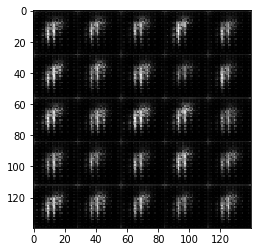

Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 1.8386
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 1.3071
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 1.4476
Epoch 1/2... Discriminator Loss: 0.5065... Generator Loss: 1.6486
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.5250
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 1.3664
Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 1.4731
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 1.1239
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 1.0158
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 1.1371


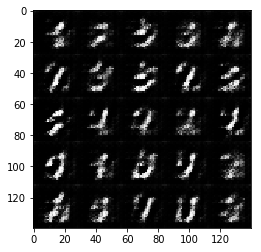

Epoch 1/2... Discriminator Loss: 0.6908... Generator Loss: 1.3056
Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 1.1738
Epoch 1/2... Discriminator Loss: 0.8071... Generator Loss: 1.3613
Epoch 1/2... Discriminator Loss: 1.4259... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 0.8493... Generator Loss: 1.3869
Epoch 1/2... Discriminator Loss: 0.8811... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 0.8061... Generator Loss: 1.5075
Epoch 1/2... Discriminator Loss: 0.9959... Generator Loss: 1.1539
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 0.7311... Generator Loss: 1.1371


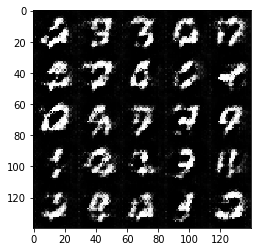

Epoch 1/2... Discriminator Loss: 0.7502... Generator Loss: 1.4248
Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 1.3219
Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 2.6912
Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 1.6679
Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 1.2292
Epoch 1/2... Discriminator Loss: 0.8646... Generator Loss: 0.8715
Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 1.3151
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 3.0349
Epoch 1/2... Discriminator Loss: 0.6856... Generator Loss: 1.0115
Epoch 1/2... Discriminator Loss: 0.4498... Generator Loss: 2.1090


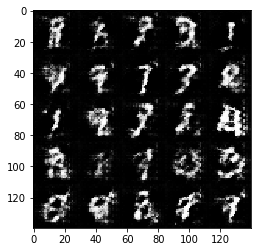

Epoch 1/2... Discriminator Loss: 0.4388... Generator Loss: 1.4970
Epoch 1/2... Discriminator Loss: 0.8800... Generator Loss: 0.6464
Epoch 1/2... Discriminator Loss: 0.3918... Generator Loss: 1.6510
Epoch 1/2... Discriminator Loss: 0.3069... Generator Loss: 2.1469
Epoch 1/2... Discriminator Loss: 0.3332... Generator Loss: 1.8306
Epoch 1/2... Discriminator Loss: 0.3156... Generator Loss: 1.8938
Epoch 2/2... Discriminator Loss: 2.6612... Generator Loss: 7.1370
Epoch 2/2... Discriminator Loss: 0.2624... Generator Loss: 2.2565
Epoch 2/2... Discriminator Loss: 0.2171... Generator Loss: 2.1381
Epoch 2/2... Discriminator Loss: 0.2070... Generator Loss: 2.1593


Epoch 2/2... Discriminator Loss: 0.1594... Generator Loss: 2.5558
Epoch 2/2... Discriminator Loss: 0.1431... Generator Loss: 2.5405
Epoch 2/2... Discriminator Loss: 0.2110... Generator Loss: 2.1383
Epoch 2/2... Discriminator Loss: 0.1682... Generator Loss: 2.6139
Epoch 2/2... Discriminator Loss: 0.0698... Generator Loss: 3.5575
Epoch 2/2... Discriminator Loss: 0.1476... Generator Loss: 2.4919
Epoch 2/2... Discriminator Loss: 0.4041... Generator Loss: 3.4581
Epoch 2/2... Discriminator Loss: 0.2979... Generator Loss: 1.8223
Epoch 2/2... Discriminator Loss: 0.1921... Generator Loss: 2.9215
Epoch 2/2... Discriminator Loss: 0.1750... Generator Loss: 2.5886


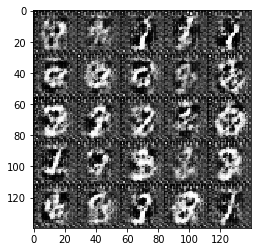

Epoch 2/2... Discriminator Loss: 0.2041... Generator Loss: 2.2652
Epoch 2/2... Discriminator Loss: 0.1593... Generator Loss: 2.3425
Epoch 2/2... Discriminator Loss: 1.6368... Generator Loss: 0.2440
Epoch 2/2... Discriminator Loss: 0.6679... Generator Loss: 3.8570
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.3584
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 0.4413
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 0.3254... Generator Loss: 2.4389
Epoch 2/2... Discriminator Loss: 0.5963... Generator Loss: 1.0292
Epoch 2/2... Discriminator Loss: 1.9606... Generator Loss: 0.1847


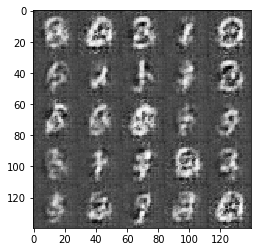

Epoch 2/2... Discriminator Loss: 0.5215... Generator Loss: 2.8587
Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 1.1481
Epoch 2/2... Discriminator Loss: 0.4241... Generator Loss: 1.8699
Epoch 2/2... Discriminator Loss: 0.5588... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 0.6507... Generator Loss: 3.5080
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 0.5336
Epoch 2/2... Discriminator Loss: 0.5115... Generator Loss: 1.3015
Epoch 2/2... Discriminator Loss: 0.6536... Generator Loss: 1.0978
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 0.8161
Epoch 2/2... Discriminator Loss: 0.4129... Generator Loss: 1.7534


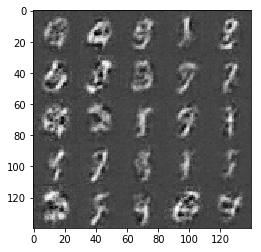

Epoch 2/2... Discriminator Loss: 0.2786... Generator Loss: 2.0480
Epoch 2/2... Discriminator Loss: 0.5559... Generator Loss: 2.9398
Epoch 2/2... Discriminator Loss: 0.3175... Generator Loss: 1.8689
Epoch 2/2... Discriminator Loss: 0.3808... Generator Loss: 2.1488
Epoch 2/2... Discriminator Loss: 0.3923... Generator Loss: 2.2011
Epoch 2/2... Discriminator Loss: 0.4120... Generator Loss: 1.4822
Epoch 2/2... Discriminator Loss: 0.3869... Generator Loss: 1.9962
Epoch 2/2... Discriminator Loss: 0.4204... Generator Loss: 1.5242
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.4821
Epoch 2/2... Discriminator Loss: 0.3781... Generator Loss: 1.9674


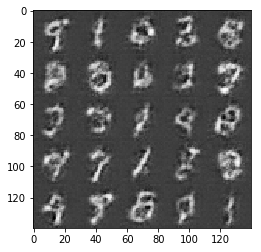

Epoch 2/2... Discriminator Loss: 0.3590... Generator Loss: 1.7481
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 0.3741... Generator Loss: 2.0039


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.7857... Generator Loss: 0.1272
Epoch 1/1... Discriminator Loss: 1.9158... Generator Loss: 0.3572
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.0249


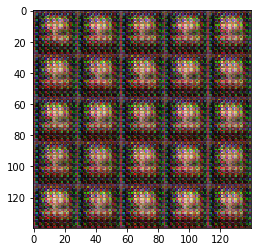

Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.2847
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.6593
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 1.6326
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 1.3883
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 1.2749
Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 1.5421
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 1.7036


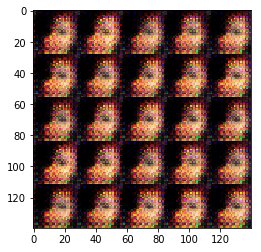

Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 1.7731
Epoch 1/1... Discriminator Loss: 0.4741... Generator Loss: 1.5463
Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 1.7804
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 1.9510
Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 1.6571
Epoch 1/1... Discriminator Loss: 0.3294... Generator Loss: 2.1459
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 1.9535
Epoch 1/1... Discriminator Loss: 0.2615... Generator Loss: 2.1667


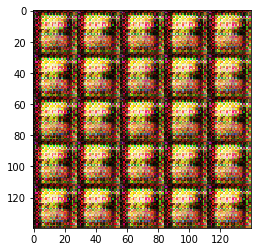

Epoch 1/1... Discriminator Loss: 0.3320... Generator Loss: 2.0198
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 2.0859
Epoch 1/1... Discriminator Loss: 0.3011... Generator Loss: 2.0983
Epoch 1/1... Discriminator Loss: 0.2519... Generator Loss: 2.3506
Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 1.8128
Epoch 1/1... Discriminator Loss: 0.2442... Generator Loss: 2.3856
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 1.9412
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 1.7552
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.4160


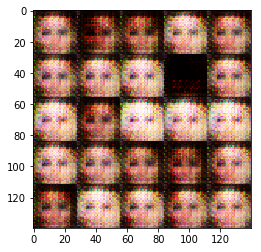

Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 1.4180
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.2051


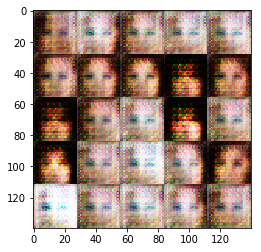

Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.3498
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.9306
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.3438
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 1.4655


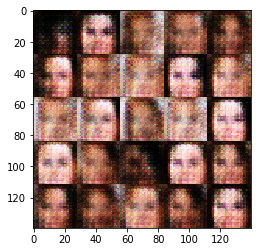

Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.8134
Epoch 1/1... Discriminator Loss: 0.4516... Generator Loss: 1.5877
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.3864
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 2.6941
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 3.5438
Epoch 1/1... Discriminator Loss: 0.6642... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 0.3165... Generator Loss: 2.1805
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.6845


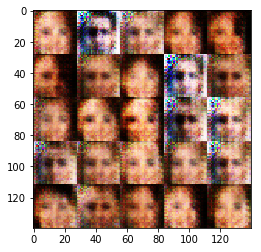

Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 2.3280
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 1.3611
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 3.0581
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 0.2556... Generator Loss: 2.3795


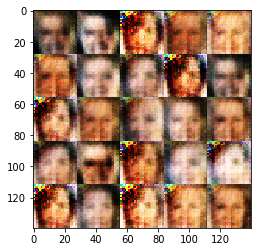

Epoch 1/1... Discriminator Loss: 0.2858... Generator Loss: 3.7422
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.9173... Generator Loss: 4.8384
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 1.5282
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 1.5817
Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 2.4611
Epoch 1/1... Discriminator Loss: 0.1915... Generator Loss: 2.3695
Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 2.3660


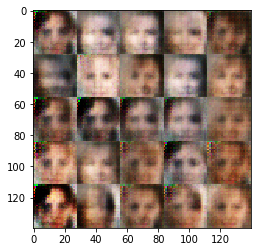

Epoch 1/1... Discriminator Loss: 0.2601... Generator Loss: 2.1450
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 3.1968
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 3.8231
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.3267
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 2.7863
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 0.2925... Generator Loss: 1.9797
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 2.7859


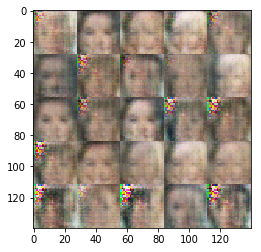

Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 0.2189... Generator Loss: 5.1387
Epoch 1/1... Discriminator Loss: 3.0770... Generator Loss: 6.0691
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 2.8366... Generator Loss: 5.4326
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 2.7921
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 2.2667
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.0965


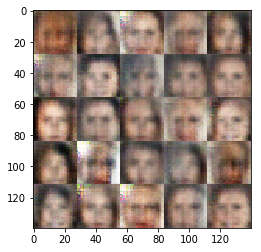

Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 0.3038... Generator Loss: 2.7388
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 0.1565... Generator Loss: 4.6803
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.4623
Epoch 1/1... Discriminator Loss: 2.1842... Generator Loss: 1.7556
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 3.2959
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 2.1664
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.4563


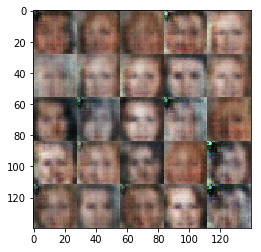

Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 1.8512
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 1.4127
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 2.9983
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 1.4130
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 2.3940
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 3.2054
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.7895
Epoch 1/1... Discriminator Loss: 0.2970... Generator Loss: 2.6478
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 1.7601
Epoch 1/1... Discriminator Loss: 0.2767... Generator Loss: 2.7156


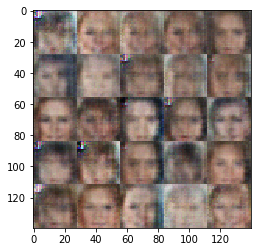

Epoch 1/1... Discriminator Loss: 0.2686... Generator Loss: 3.6973
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 1.6052
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 2.4625
Epoch 1/1... Discriminator Loss: 0.3052... Generator Loss: 2.1644
Epoch 1/1... Discriminator Loss: 0.2738... Generator Loss: 3.1330
Epoch 1/1... Discriminator Loss: 0.1998... Generator Loss: 4.6140
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 2.0385
Epoch 1/1... Discriminator Loss: 0.2635... Generator Loss: 4.5303
Epoch 1/1... Discriminator Loss: 0.1347... Generator Loss: 4.2047
Epoch 1/1... Discriminator Loss: 0.5523... Generator Loss: 1.3005


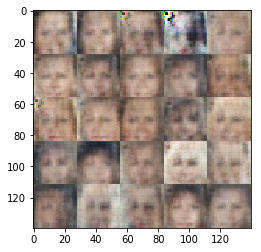

Epoch 1/1... Discriminator Loss: 0.0982... Generator Loss: 3.4647
Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 1.8510
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 5.6745
Epoch 1/1... Discriminator Loss: 0.1548... Generator Loss: 3.7786
Epoch 1/1... Discriminator Loss: 0.1076... Generator Loss: 3.6041
Epoch 1/1... Discriminator Loss: 0.1367... Generator Loss: 4.0392
Epoch 1/1... Discriminator Loss: 0.1178... Generator Loss: 3.9935
Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 1.2591
Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 1.6301
Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 1.8571


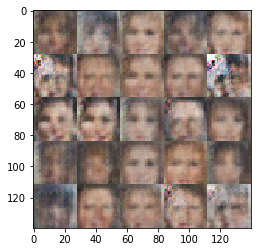

Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 2.0787
Epoch 1/1... Discriminator Loss: 0.2792... Generator Loss: 3.6976
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 2.3819
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 2.6544
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 1.3171
Epoch 1/1... Discriminator Loss: 0.2886... Generator Loss: 2.4151
Epoch 1/1... Discriminator Loss: 0.5437... Generator Loss: 1.6567
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 0.9730


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.